In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up variables

In [2]:
# Problem data.
m = 8
n_values = [25, 50, 100, 250, 500, 1000]
b = np.ones(m)

In [3]:
# Number of times to solve the dual equation.
num_dual_samples = 1000

# Number of times to solve the stochastic equation.
num_stoc_samples = 10**5

In [4]:
# Set random seed for reproducability.

np.random.seed(23)

# Solve for the stochastic program

In [5]:
# Solve for the stochastic program.

# This is deterministic.

# From TA office hours: We cannot use the expectations
# of A and pi instead of their samples of A and pi,
# because we cannot exchange the function and inequality.
# Therefore, we have to generate very many samples of A 
# and pi, and truly calculate the expectation.
print("Stochastic Program Results")

# Create dictionary to store stochastic program results
n_to_stochastic_p = dict()

start = time.time()

for n in n_values:
    # Solve the stochastic problem.
    d = b / n
    
    # Construct the stochastic problem.
    p = cp.Variable(m)
    
    A = np.random.uniform(-0.5, 1, (m, num_stoc_samples))
    pi = np.random.uniform(0, 10, num_stoc_samples)
        
    objective = cp.Minimize((d @ p) + (1/num_stoc_samples)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p))))

    constraints = [p >= 0]

    prob = cp.Problem(objective, constraints)

    # Solve the stochastic problem.
    result = prob.solve()
    now = time.time()
    print("\nWith n=%d, iteration completed in %.2f s" % (n, now - start))
    print(p.value)
    
    n_to_stochastic_p[n] = p.value
    

Stochastic Program Results

With n=25, iteration completed in 3.33 s
[3.47018361 3.60440378 3.49757671 3.49494223 3.54089082 3.60054291
 3.58043596 3.62668028]

With n=50, iteration completed in 7.04 s
[4.50218203 4.62056572 4.60527359 4.54591714 4.63357121 4.58783448
 4.73314006 4.70131174]

With n=100, iteration completed in 14.89 s
[5.90210873 5.89692588 5.82713287 5.74306472 5.82155358 5.79770519
 5.87194697 5.72577685]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



With n=250, iteration completed in 25.44 s
[7.10793603 7.40825902 7.375411   7.30782941 7.34646281 7.42978357
 7.1612458  7.33080315]

With n=500, iteration completed in 36.07 s
[8.29183932 8.37757052 8.31529482 8.34767714 8.49039816 8.23702808
 8.48124607 8.12506524]

With n=1000, iteration completed in 46.53 s
[9.27253814 9.10485725 9.28124482 9.15030622 9.40414258 9.12853445
 9.42310861 9.31496553]


# Solve for the dual problem for various values of n

In [6]:
# Create dictionaries to save results of simulations

n_to_diffs = dict()
n_to_mean_diffs = dict()
n_to_log_factors = dict()
n_to_C = dict()

##########################################################
# Solve the dual problem.
    
for n in n_values:
    d = b / n
    
    # Create an array to store all of the simulations.
    p_n_values = np.zeros((num_dual_samples, m))
    
    # Solve for one iteration of the offline dual optimal solution.
    for i in range(num_dual_samples):
        # Generate sample A_j and pi_j's (all at once in array)
        A = np.random.uniform(-0.5, 1, (m, n))
        pi = np.random.uniform(0, 10, n)

        # Construct the stochastic problem.
        p_n = cp.Variable(m)

        # We could do the sum of up to t terms if this was truly online;
        # however since this is offline we can use matrix operations.

        objective = cp.Minimize((d @ p_n) + (1/n)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p_n))))

        constraints = [p_n >= 0]

        prob = cp.Problem(objective, constraints)

        # Solve the offline dual problem.
        result = prob.solve()

        p_n_values[i] = p_n.value
        
        
    
    # Compute the 2-norm difference from the stochastic solution
    diffs = [np.linalg.norm(p_n_values[i]-n_to_stochastic_p[n], ord=2)**2 for i in range(num_dual_samples)]
    
    # Compute the log difference based on m and n
    log_factor = m*np.log(m)*np.log(np.log(n))/n
    
    # Compute the coefficient C from dividing the mean of the differences by the log_factor
    C = np.mean(diffs) / log_factor
    
    # Save all results to the dictionary
    n_to_diffs[n] = diffs
    n_to_mean_diffs[n] = np.mean(diffs)
    n_to_log_factors[n] = log_factor
    n_to_C[n] = C
    
    # Print results
    print("For n = %d" % (n))
    print("Average of all dual solutions: %s" % (np.mean(p_n_values, axis=0)))
    print("Expectation of L2 norm between p*n and p* is: %.2f" % (np.mean(diffs)))
    print("m log m log log n / n for m=%d and n=%d is: %.2f" % (m, n, log_factor))
    print("Constant C is: %.3f\n" % (C))

For n = 25
Average of all dual solutions: [3.46373412 3.59897885 3.54730438 3.49929062 3.55825205 3.66550874
 3.21276653 3.50909532]
Expectation of L2 norm between p*n and p* is: 86.05
m log m log log n / n for m=8 and n=25 is: 0.78
Constant C is: 110.622

For n = 50
Average of all dual solutions: [4.88421408 4.80858017 4.63642416 4.82399445 4.7129947  4.69877138
 4.79913588 4.67233957]
Expectation of L2 norm between p*n and p* is: 83.92
m log m log log n / n for m=8 and n=50 is: 0.45
Constant C is: 184.903

For n = 100
Average of all dual solutions: [6.00705802 6.02931675 6.15362198 6.24937711 6.08664971 5.87197325
 6.21891066 5.98678808]
Expectation of L2 norm between p*n and p* is: 68.18
m log m log log n / n for m=8 and n=100 is: 0.25
Constant C is: 268.373

For n = 250
Average of all dual solutions: [7.74286896 7.83069975 7.71263483 7.73474459 7.72143692 7.83235839
 7.78689376 7.74190926]
Expectation of L2 norm between p*n and p* is: 47.29
m log m log log n / n for m=8 and n=250 i

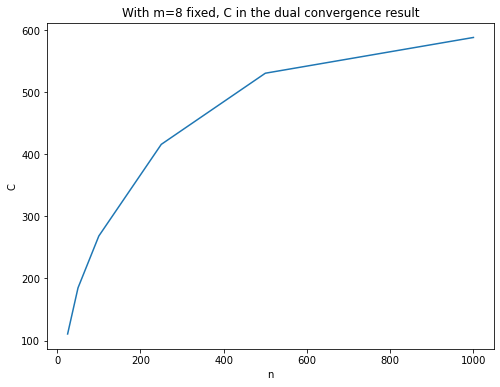

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_C.keys()), list(n_to_C.values()))
plt.xlabel("n")
plt.ylabel("C")
plt.title("With m=%d fixed, C in the dual convergence result" % (m))
plt.show()

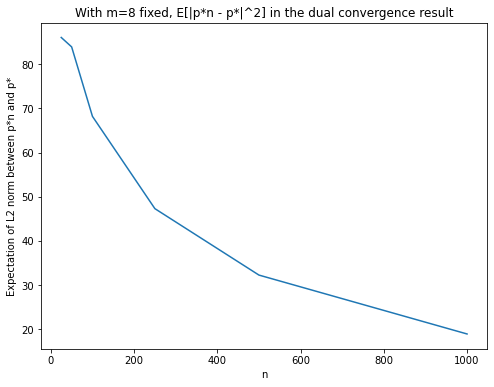

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_diffs.keys()), list(n_to_mean_diffs.values()))
plt.xlabel("n")
plt.ylabel("Expectation of L2 norm between p*n and p*")
plt.title("With m=%d fixed, E[|p*n - p*|^2] in the dual convergence result" % (m))
plt.show()